# Tutorial 1: 10X Visium

In this tutorial, we show how to apply GraphST to identify spatial domains on 10X Visium data. As a example, we analyse the 151673 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

We derived the preprocessed data from the spatialLIBD package, including manual annotations. Before running the model, please download the input data via https://drive.google.com/drive/folders/1DocCbwz5_ADyO_lnarjAIi1KKLSqtizB.

## Loading package

In [ ]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from pathlib import Path
import matplotlib.pyplot as plt
# import importlib

In [19]:
from GraphST import GraphST
# importlib.reload(GraphST)

In [ ]:
# print(GraphST.__file__)

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/GraphST/GraphST.py


In [ ]:
# !cat /home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/GraphST/GraphST.py | grep "def train(" -A 20

    def train(self):
        if self.datatype in ['Stereo', 'Slide']:
           self.model = Encoder_sparse(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        else:
           self.model = Encoder(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        self.loss_CSL = nn.BCEWithLogitsLoss()
    
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.learning_rate, 
                                          weight_decay=self.weight_decay)
        
        print('Begin to train ST data...')
        print('Debugging')
        self.model.train()
        
        for epoch in tqdm(range(self.epochs)): 
            self.model.train()
              
            self.features_a = permutation(self.features)
            self.hiden_feat, self.emb, ret, ret_a = self.model(self.features, self.features_a, self.adj)
            
            self.loss_sl_1 = self.loss_CSL(ret, self.label_CSL)


In [22]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
# os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [23]:
# the number of clusters
n_clusters = 7

In [24]:
dataset = '151673'

## Reading ST data

The necessary input files includes:
1) The gene expression matrix: filtered_feature_bc_matrix.h5;
2) Spatial coordinates: position.txt;
3) Histology image: the format should be .png.    
    
In the example, position inforamtion has been saved in adata.obsm['spatial']. To make the model can read the data sucessfully, 
please ensure the same format input file as example.

In [25]:
# read data
file_fold = '/home/lytq/GraphST/data/DLPFC/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [26]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [27]:
df_meta = pd.read_csv(Path(file_fold) / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [28]:
adata.obs['layer_guess']

AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGCTTTCAGAAG-1    Layer5
                       ...  
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
TTGTTTGTGTAAATTC-1    Layer2
Name: layer_guess, Length: 3639, dtype: object

## Training the model

GraphST model aims to learn the representations for spots by making full use of gene expressions and spatial location information in a self-supervised learning way.
After model training, the learned representations will be saved in adata.obsm['emb'], and can be used for spatial clustering. 

In [29]:
# define model
model = GraphST.GraphST(adata, device=device)

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'count'


In [30]:
# train model
adata = model.train()

Begin to train ST data...
Debugging


100%|██████████| 600/600 [00:09<00:00, 61.25it/s]

Optimization finished for ST data!


In [31]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'
    layers: 'count'

## Spatial clustering and refinement

In the clustering result, some spots may be wrongly assigned to spatially disparate domains. 
We consider such occurrences to be noise and their presence may influence downstream biological analysis. 
Therefore, we extend our GraphST model with an optional optimization step to remove the noises. In short, for a given spot,
its lable will be re-assigned as the same domain as the most common lable of its surronding spots (please refer to the manuscript for more details).
To do so, parameter 'radius' is set to specify the number of neighbors.

Please note that this step is not recommended for ST data with fine-grained domains (e.g., mouse brain anterior and posterior), Stereo-seq, and Slide-seqV2.
In this study, we only applied this refinement step to the human brain DLPFC and the human breast cancer dataset.

After model training, the representation for spots are generated and used as input of clustering tool for spatial clustering. Here we provid three available kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [45]:
os.environ['R_HOME'] = '/home/lytq/.conda/envs/SEDR/lib/R'
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False) 

fitting ...
  |======================================================================| 100%


In [54]:
low_dim_data = pd.DataFrame(adata.obsm['feat'], index=adata.obs.index)
expression_data = pd.DataFrame(adata.layers['count'], index=adata.obs.index, columns=adata.var.index)
cell_metadata = adata.obs

os.makedirs("/home/lytq/GraphST/results/data_Monocle3", exist_ok=True)
low_dim_data.to_csv("/home/lytq/GraphST/results/data_Monocle3/low_dim_data.csv")
expression_data.T.to_csv("/home/lytq/GraphST/results/data_Monocle3/expression_matrix.csv")
cell_metadata.to_csv("/home/lytq/GraphST/results/data_Monocle3/cell_metadata.csv")
expression_data

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualization

For DLPFC data, the original authors manually annotated the slices. The annotation (metadata.tsv) for 151673 slice can be downloaded from https://drive.google.com/drive/folders/1DocCbwz5_ADyO_lnarjAIi1KKLSqtizB. 
For quantitative assessment, we use well-known ARI metric to evaulate the performance. 
Since not all of spots were annotated, we filtered out NA nodes before the ARI calculation and visualization. 

In [47]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [48]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])] 
        
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
    
print('Dataset:', dataset)
print('ARI:', ARI)

/tmp/ipykernel_2478917/718994305.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: 151673
ARI: 0.636227338418555


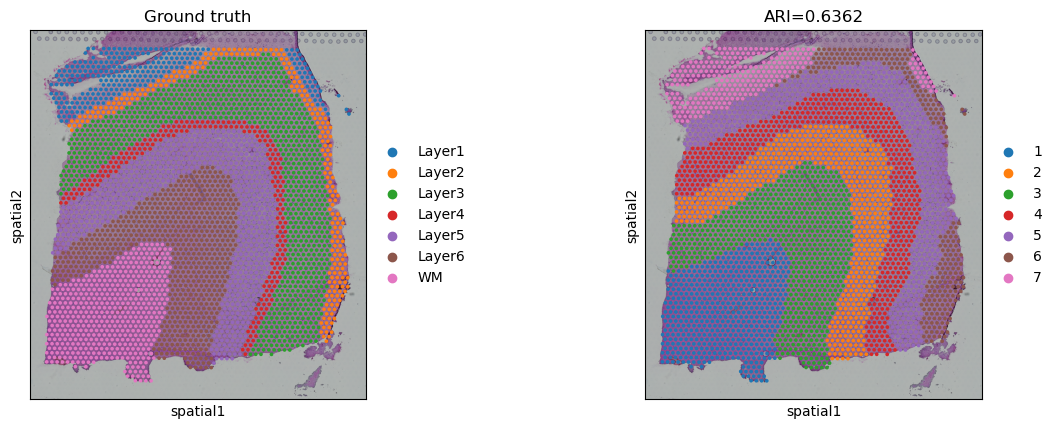

In [49]:
# plotting spatial clustering result
sc.pl.spatial(adata, 
              img_key="hires", 
              color=["ground_truth", "domain"], 
              title=["Ground truth", "ARI=%.4f"%ARI], 
              show=True)

The learned representations will be incluced in adata.obsm['emb'] or adata.obsm['emb_pca'] (PCA dimension reduction), which can be used for UMAP visualization.

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

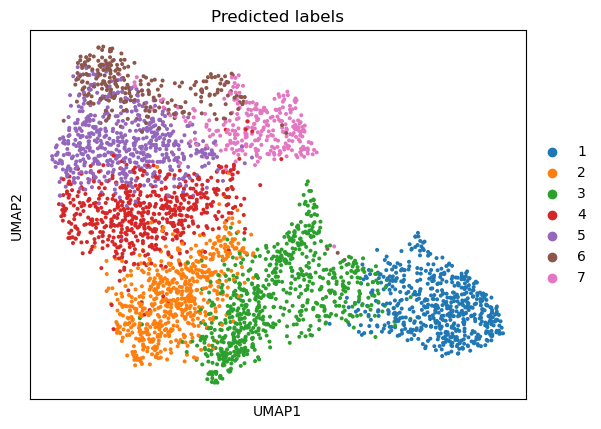

In [50]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

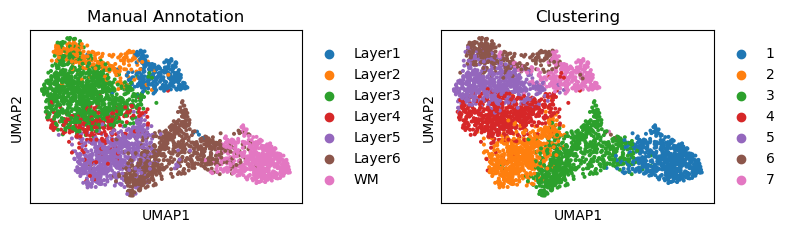

In [51]:
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)

fig, axes = plt.subplots(1,2,figsize=(4*2, 3))
sc.pl.umap(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.umap(adata, color='domain', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering')

for ax in axes:
    ax.set_aspect(1)

plt.tight_layout()
plt.show()

In [55]:
adata

AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess', 'mclust', 'domain', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'ARI', 'ground_truth_colors', 'domain_colors', 'neighbors', 'umap', 'layer_guess_colors'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca', 'X_umap'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [ ]:
umap_coords = adata.obsm["X_umap"]  
spot_ids = adata.obs_names  # spot ID

umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids  #  
# adjust order
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]

# umap_df.to_csv("spatial_umap_coords.csv", index=False)

umap_df.to_csv("/home/lytq/GraphST/results/data_Monocle3/spatial_umap_coords.csv", index=False)
umap_df

,spot_id,UMAP1,UMAP2
0,AAACAAGTATCTCCCA-1,-3.091993,7.154270
1,AAACAATCTACTAGCA-1,3.521184,7.716909
2,AAACACCAATAACTGC-1,12.033881,0.594100
3,AAACAGAGCGACTCCT-1,-3.068541,6.222774
4,AAACAGCTTTCAGAAG-1,4.082997,1.114004
...,...,...,...
3606,TTGTTTCACATCCAGG-1,11.988874,0.096735
3607,TTGTTTCATTAGTCTA-1,11.485796,1.145380
3608,TTGTTTCCATACAACT-1,6.645387,2.339695
3609,TTGTTTGTATTACACG-1,8.174377,2.903210


In [57]:
adata.obs['domain']

AAACAAGTATCTCCCA-1    5
AAACAATCTACTAGCA-1    7
AAACACCAATAACTGC-1    1
AAACAGAGCGACTCCT-1    5
AAACAGCTTTCAGAAG-1    3
                     ..
TTGTTTCACATCCAGG-1    1
TTGTTTCATTAGTCTA-1    1
TTGTTTCCATACAACT-1    3
TTGTTTGTATTACACG-1    1
TTGTTTGTGTAAATTC-1    6
Name: domain, Length: 3611, dtype: category
Categories (7, object): ['1', '2', '3', '4', '5', '6', '7']